## Market Basket Analysis (MBA) - Transactions from a Bakery
------

In this notebook, transactions of a bakery taken from [Kaggle](https://www.kaggle.com/sulmansarwar/transactions-from-a-bakery) will be analyzed to determine consumer behaviour and future marketing strategies.

In [1]:
# Import packages
# Basics
import pandas as pd
import numpy as np
import itertools as it
from collections import Counter

# Graphs
import seaborn as sns
from matplotlib import pyplot as plt

# MBA
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Import and load .csv file
df = pd.read_csv("bakery.csv")
df.head()

,Date,Time,Transaction,Item
0,2016-10-30,09:58:11,1,Bread
1,2016-10-30,10:05:34,2,Scandinavian
2,2016-10-30,10:05:34,2,Scandinavian
3,2016-10-30,10:07:57,3,Hot chocolate
4,2016-10-30,10:07:57,3,Jam


The output above shows the first 5 rows of the dataset, and below is a description of the dataset from the Kaggle page:

*The dataset consists of 21293 observations from a bakery. The data file contains four variables, Date, Time, Transaction ID and Item. Transaction ID ranges from 1 through 9684. However, there are some skipped numbers in Transaction IDs. Also, there are duplicated entries, as shown in observation # 2 and #3. Besides, the Item contains "Adjustment", "NONE", and "Afternoon with the baker". While the entries of "Adjustment" and "NONE" are straight forward, "Afternoon with the baker" may be a real purchase.*

The description above implies that some data cleaning will be needed before performing the analysis. First, let's verify if the dataset contains any duplicate entries or skipped numbers in transaction ID.

In [2]:
# Checking for missing numbers in the transaction ID
minimum = min(df.Transaction)
maximum = max(df.Transaction)

for i in range(minimum, maximum + 1):
    if any(df.Transaction == i):
        continue
    elif i == maximum & any(df.Transaction == i):
        output = "No"
        break
    else:
        output = "Yes"
        break

print("Are there transactions ID missing?", output)
print("Are there any duplicates?", any(df.duplicated()))

Are there transactions ID missing? Yes
Are there any duplicates? True


From the output above, it seems like there are some skipped numbers in transaction ID. We will leave transaction ID alone for now, as it acts as unique identifier for each transaction which will be cruicial for establishing rules later on.

On the other hand, the following rows will be dropped from the dataset as part of the data cleaning process:
- Duplicated columns using `pd.drop_duplicates`
- Columns with "Adjustment" or "NONE" using `pd.drop` as items as they add no value to the analysis

In [3]:
# Shape before data cleaning
print("DataFrame shape before dropping rows:", df.shape)

# Dropping rows that have "Adjustment" or "NONE" as transaction
for item in ["Adjustment","NONE"]:
    indexes = df[df.Item == item].index
    df.drop(index = indexes, inplace = True)

# Dropping duplicates and reset index
df.drop_duplicates(inplace = True)
df = df.reset_index()
df.drop(columns = "index",inplace=True)

# Shape after data cleaning
print("DataFrame shape after dropping rows:", df.shape)

DataFrame shape before dropping rows: (21293, 4)
DataFrame shape after dropping rows: (18886, 4)


The number of rows is reduced from 21,293 to 18,886 after data cleaning. Next, the items of each transaction will be aggregated into a list of lists, which is the format needed to utilize [`TransactionEncoder`](http://rasbt.github.io/mlxtend/user_guide/preprocessing/TransactionEncoder/) in `mlxtend`, an encoder class for transaction data. The idea of `TransactionEncoder` is to create a matrix with the columns being items purchased. The encoder will encode True/False according for each column based on which item(s) is/are in each transaction. 

In [4]:
# Putting items into lists, using transaction number as the unique identifier
transaction_list = []

number = 0

for num in df.Transaction.values:
    if num != number:
        transaction = list(df.Item[df.Transaction == num].values)
        transaction_list.append(transaction)
        number = num

# display first 10 transactions
print("Transactions in a list of lists:")
display(transaction_list[:10])

# Encode transactions using TransactionEncoder
encoder = TransactionEncoder()
bakery = encoder.fit(transaction_list).transform(transaction_list)
bakery_df = pd.DataFrame(bakery, columns = encoder.columns_)
print("Output from TransactionEncoder:")
bakery_df.head()

Transactions in a list of lists:


[['Bread'],
 ['Scandinavian'],
 ['Hot chocolate', 'Jam', 'Cookies'],
 ['Muffin'],
 ['Coffee', 'Pastry', 'Bread'],
 ['Medialuna', 'Pastry', 'Muffin'],
 ['Medialuna', 'Pastry', 'Coffee', 'Tea'],
 ['Pastry', 'Bread'],
 ['Bread', 'Muffin'],
 ['Scandinavian', 'Medialuna']]

Output from TransactionEncoder:


,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,Bowl Nic Pitt,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


Some preliminary analysis can be done once the data has been processed. First, let's take a look at which are the top items sold at the bakery. We can take a look at the data in 2 ways - based on the number of items sold and the support of the item(s), which is the proportion of the transactions that contain a certain item.

The top 10 number of items sold is calculated by the total of items purchased, and the top 10 support is calculated using Apriori Algorithm in [`mlxtend`](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/). The algorithm returns the support for an item, or a combination of items, which will be important in association rule learning later on.

In [5]:
def barplots(x,y,color,xlabel,ylabel,
             title,orient = "v",figsize = (20,8)):
    '''
    This function creates seaborn barplots, with the option of showing values on the graph.
    
    Input:
    ------
    x = input for x-axis
    y = input for y-axis
    color = color for the bars of the graph
    xlabel = label name for x-axis
    ylabel = label name for y-axis
    title = title name
    orient = orientation of the graph. "h" = horizontal, "v" = vertical
    figsize = size of the graph as used in plt.figure()
    
    Output:
    ------
    A seaborn barplot
    
    '''
    # Function for showing values on barplots
    # Modified from this code source: 
    # https://stackoverflow.com/questions/43214978/seaborn-barplot-displaying-values
    def show_values_on_bars(axs, orient = "h"):
        '''
        This function show values on barplots.
        '''
        def _show_on_single_plot(ax):
            if orient == "h":               # for horizontal barplots
                for p in ax.patches:
                    _x = p.get_x() + p.get_width()
                    _y = p.get_y() + p.get_height() / 1.5
                    if p.get_width() >= 1:   # for transaction count
                        value = '{:.0f}'.format(p.get_width())
                        ax.text(_x, _y, value, ha="left", fontsize=20)
                    else:                    # for anything that is in fraction (eg. support)
                        value = '{:.3f}'.format(p.get_width())
                        ax.text(_x, _y, value, ha="left", fontsize=20)

            else:                            # for vertical barplots
                for p in ax.patches:
                    _x = p.get_x() + p.get_width() / 2
                    _y = p.get_y() + p.get_height()
                    if p.get_height() >= 1:  # for transaction count
                        value = '{:.0f}'.format(p.get_height())
                        ax.text(_x, _y, value, ha="center", fontsize=20)
                    else:                    # for anything that is in fraction (eg. support)
                        value = '{:.3f}'.format(p.get_height())
                        ax.text(_x, _y, value, ha="center", fontsize=20)

        if isinstance(axs, np.ndarray):
            for idx, ax in np.ndenumerate(axs):
                _show_on_single_plot(ax)
        else:
            _show_on_single_plot(axs)

    # plotting the graphs
    plt.figure(figsize = figsize)
    ax1 = sns.barplot(x = x, y = y, color = color)
    show_values_on_bars(ax1, orient = orient)
    plt.xlabel(xlabel, size = 20)
    plt.ylabel(ylabel, size = 20)
    if orient == "v":
        plt.xticks(rotation = 40, size = 20)
    else:
        plt.xticks(size = 20)
    plt.yticks(size = 20)
    plt.title(title, size = 25)
    
    return plt.show();

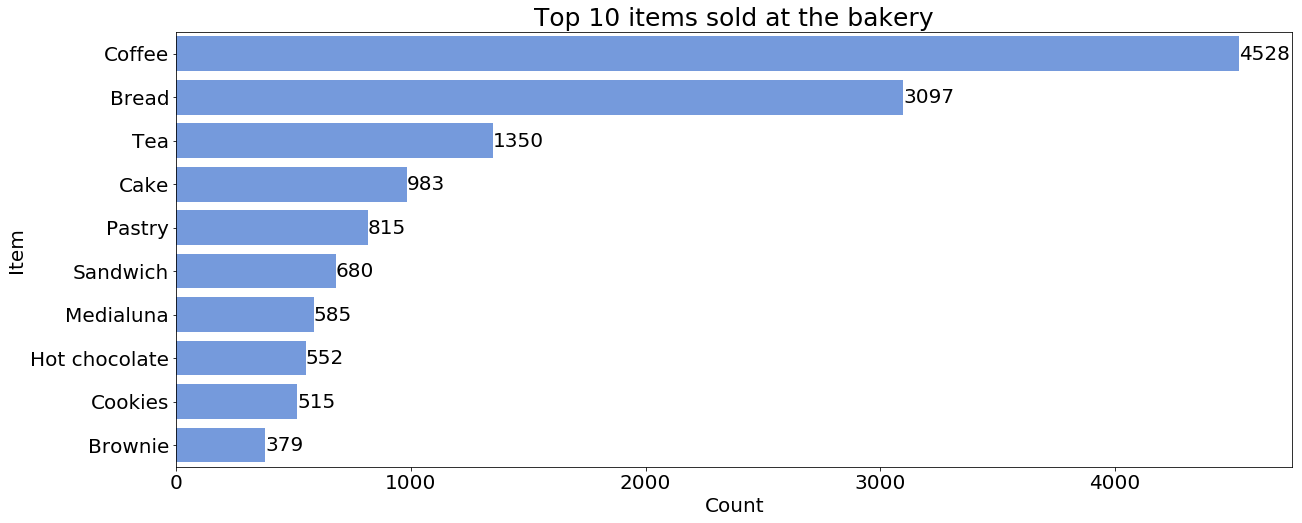

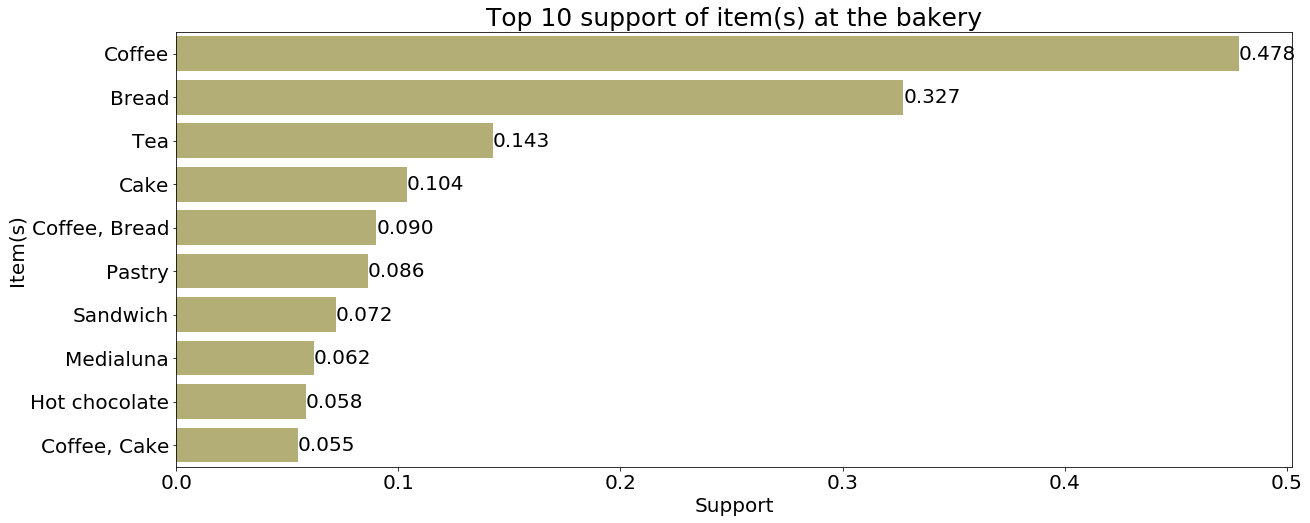

In [6]:
length = 10
max_len = max(df.Transaction.groupby(df.Transaction).count())

# Calculate top n items sold
top_n = bakery_df.sum().sort_values(ascending = False)[:length]

# Calculate top n support
support_table = apriori(bakery_df, min_support = 0.01, 
                        use_colnames = True, max_len = max_len)
support_table = support_table.sort_values(by = "support", 
                                          ascending = False).reset_index()
support_table.drop(columns = "index",inplace=True)
top_n_support = support_table.head(10)

# process strings of transaction items for the graphs
item_list = []
sets = top_n_support.itemsets.values
for num in range(len(sets)):
    try:   
        item, = top_n_support.itemsets[num]
        item_list.append(item)
    except ValueError:
        temp_list = []
        item_iter = iter(sets[num])
        for i in range(len(sets[num])):
            temp_list.append(next(item_iter))
        string = ', '.join(temp_list)
        item_list.append(string)

# Plotting the graph
barplots(x = top_n.values, y = top_n.index, 
         color = "cornflowerblue", xlabel = "Count",
         ylabel = "Item",
         title = f"Top {length} items sold at the bakery",
         orient = "h")

barplots(x = top_n_support.support, y = item_list, 
         color = "darkkhaki", xlabel = "Support",
         ylabel = "Item(s)",
         title = f"Top {length} support of item(s) at the bakery",
         orient = "h")

From the graphs above, it seems like coffee, bread, tea and cake are the most purchased items from the bakery. The highest support for combinations of items is coffee and bread, with 9% of the transactions containing such combination.

Next, we will explore the relationships between items using [`association rules`](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/). Here we are trying to learn the rules of associations between items to inform us of which items are more likely to be purchased together or as substitutes. By learning consumer behaviour, we can design promotions or marketing efforts to promote cross-sell and upsell.

We will use the following metrics to guide our exploration -

**Support -**

Support is the proportion of transactions that contain the given combination of items. It determines **how often does the combination occur** and thus, whether such association is worth pursuing.

**Lift -**

Lift is a metric that determines how much the purchase of the consequence is lifted by the antecedent. A lift of 1 indicates no increase. It determines **how much we drive the sales of the consequence** by the relationship.

**Confidence -**

Confidence is how likely the combination is going to happen. It determines the **strength of the rule**.

A confidence towards 1 indicate the combination will always happen. A confidence equals to consequent support indicates the combination occurs at random. A confidence that is less than consequent support indicates the item is a substitute.

------

First, let's look at the association rules for all possible combinations that have equal to or higher than 1% of chance occurring (i.e support) and explore the relationship between the three metrics.

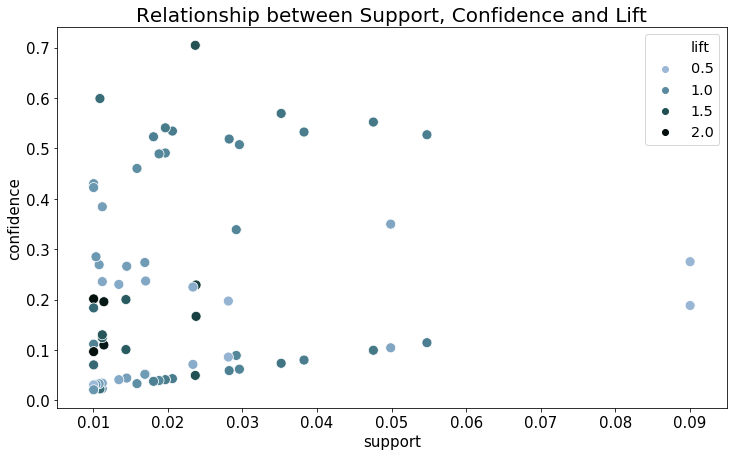

In [7]:
# Calculate association rules
rules_table = association_rules(support_table, metric = "support", 
                                min_threshold = 0.0)

# Graph the results
plt.figure(figsize = (12,7))
cmap = sns.cubehelix_palette(n_colors=3, start = 2.3, rot=.2, 
                             light=0.7, dark=0.05, as_cmap = True)
sns.scatterplot(x = rules_table.support, y = rules_table.confidence, 
                hue = rules_table.lift, s=100, palette = cmap)
plt.xlabel("support", size = 15)
plt.ylabel("confidence", size = 15)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend(fontsize = "x-large")
plt.title("Relationship between Support, Confidence and Lift", 
          size = 20)
plt.show();

The graph above illustrates the relationships between the different metrics. According to this [website](https://select-statistics.co.uk/blog/market-basket-analysis-understanding-customer-behaviour/), it has been shown that the optimal rules are those that lie on what's known as the "support-confidence boundary", which is the right hand border of the plot where rither support, confidence or both are maximized.

We can see that there are 2 rules that have the highest support. Let's investigate those rules a bit more.

In [8]:
# print out the results for those 2 rules
rules_table.sort_values(by = "support", ascending = False).head(2)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Coffee),(Bread),0.478445,0.327240,0.090025,0.188163,0.574998,-0.066541,0.828688
1,(Bread),(Coffee),0.327240,0.478445,0.090025,0.275105,0.574998,-0.066541,0.719491


Coffee and bread have the highest support (0.09) out of all combinations. However, the confidence for both combinations (0.18 / 0.27) are lower than the conseqent support for coffee (0.47) and bread (0.32). Therefore, **coffee and bread are substitute products**, which are items that replace each other. This is possibly because coffee and bread serve different purpose to customers. Good coffee appeals to customers who are looking for that morning coffee, or a "pick-me-up" during the day. Those who purchase bread from the bakery may consume bread as a staple of their diet and not necessarily need a cup of coffee during their shopping.

Since we are interested in combinations that promote cross-sell and upsell, let's take a look at combinations that:

- Are not substitute products and combinations does not occur by random chance (i.e confidence higher than consequent support)
- Drives the sale of the consequence (i.e lift > 1)
- Occur as frequently as possible (in this case we will choose the top 10 support values)

In [9]:
# association rules with above constraints
new_table = rules_table[(rules_table.confidence > rules_table["consequent support"]) 
                        & (rules_table.lift > 1)]
new_table.nlargest(10, "support").sort_values(by = "confidence", ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
10,(Medialuna),(Coffee),0.061813,0.478445,0.035186,0.569231,1.189753,0.005612,1.210754
6,(Pastry),(Coffee),0.086116,0.478445,0.047549,0.552147,1.154046,0.006347,1.164569
9,(Sandwich),(Coffee),0.071851,0.478445,0.038250,0.532353,1.112674,0.003873,1.115276
3,(Cake),(Coffee),0.103867,0.478445,0.054734,0.526958,1.101399,0.005039,1.102557
13,(Hot chocolate),(Coffee),0.058326,0.478445,0.029586,0.507246,1.060199,0.001680,1.058451
2,(Coffee),(Cake),0.478445,0.103867,0.054734,0.114399,1.101399,0.005039,1.011893
7,(Coffee),(Pastry),0.478445,0.086116,0.047549,0.099382,1.154046,0.006347,1.014730
8,(Coffee),(Sandwich),0.478445,0.071851,0.038250,0.079947,1.112674,0.003873,1.008799
11,(Coffee),(Medialuna),0.478445,0.061813,0.035186,0.073542,1.189753,0.005612,1.012660
12,(Coffee),(Hot chocolate),0.478445,0.058326,0.029586,0.061837,1.060199,0.001680,1.003743


Upon first glance, it seems like a variety of products drives the sale of **coffee**. Since we would want to pursue combinations that occurs more often with a strong rule strength, a combo or promotions for **pastry** with coffee would be worthwhile to pursue. For an unique flavour, a promotion for **Medialuna** (Sweet Crescent Rolls from Argentina) with coffee would attract customers that are looking for something different.

Would there be any relationship that does not involve coffee that is worth exploring?

In [10]:
# association rules without coffee
no_coffee = new_table[(new_table.antecedents != {'Coffee'}) & 
                      (new_table.consequents != {'Coffee'})]
no_coffee.sort_values(by = "confidence", ascending = False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
14,(Pastry),(Bread),0.086116,0.327240,0.029163,0.338650,1.034868,0.000983,1.017253
21,(Cake),(Tea),0.103867,0.142646,0.023774,0.228891,1.604612,0.008958,1.111846
68,"(Coffee, Tea)",(Cake),0.049873,0.103867,0.010038,0.201271,1.937773,0.004858,1.121949
44,(Sandwich),(Tea),0.071851,0.142646,0.014370,0.200000,1.402074,0.004121,1.071693
49,(Hot chocolate),(Cake),0.058326,0.103867,0.011412,0.195652,1.883675,0.005353,1.114111
69,"(Coffee, Cake)",(Tea),0.054734,0.142646,0.010038,0.183398,1.285686,0.002231,1.049904
20,(Tea),(Cake),0.142646,0.103867,0.023774,0.166667,1.604612,0.008958,1.075359
53,(Pastry),"(Coffee, Bread)",0.086116,0.090025,0.011200,0.130061,1.444719,0.003448,1.046022
52,"(Coffee, Bread)",(Pastry),0.090025,0.086116,0.011200,0.124413,1.444719,0.003448,1.043739
63,"(Coffee, Bread)",(Cake),0.090025,0.103867,0.010038,0.111502,1.073508,0.000687,1.008593


Since the support for all results above are quite low (<0.03), the results are ordered by confidence to get a sense of which combinations are more worthwhile to explore. It seems like we can encourage customers purchasing **pastry** to add on some **bread**, and customers who wants **cake** to accompany the cake with a cup of **tea**. 

## Conclusion
------

**In conclusion**, below are some insights and recommendations generated from the transactions using Market Basket Analysis:

- Although **coffee and bread** are the 2 most purchased items of the bakery, customers tend to purchase them **separately**
- Consider offering **combo deals** or **promotions** for the following:
<br>
&emsp; a) Pastry with coffee
<br>
&emsp; b) Medialuna with coffee
<br>
&emsp; c) Pastry with bread
<br>
&emsp; d) Cake with tea